# This code is intended to be used for offline analysis of the magnetic data retreived from the WebDAQ and Minimus during site surveying.

## You may need to update the widget package to make this work.

## pip install ipywidgets --upgrade
## conda install conda-forge::ipywidgets

# Do not run all
# Run one cell at a time or plots may not populate

In [1]:
print("thinking...")
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, IntSlider
print("thinking...")
from ipywidgets import FloatSlider
from ipywidgets import Layout 
from scipy import signal
from matplotlib import gridspec
print("thinking...")
from scipy.fft import fftshift
import warnings

################################################################################################################################


path = r"C:\Users\cacam\Documents\data_files\10-01-compare\seismo_test_cal_2024-10-01T22-07-09-752.csv"


################################################################################################################################

metadata_rows = []
metadata = {}

with open(path, 'r') as f:
    for _ in range(5):
        metadata_rows.append(f.readline().strip()) 

for row in metadata_rows:
    if ':' in row: 
        key, value = row.split(':', 1)
        metadata[key.strip()] = value.strip()
     
    
########################################### This is the sample rate from the metadata ##########################################
sr = float(metadata["Sample Rate"])
print("\nSample Rate: " + metadata["Sample Rate"]) ############# Prints out the sample rate as a sanity check ################
################################################################################################################################
                 
seis = pd.read_csv(path, skiprows = 5, delimiter=',') 

seis.columns = ["Sample", "Time (s)", "Noise (V)", "Channel E (V)", "Channel N (V)", "Channel Z (V)", "blank"]

sam = seis['Sample']
tim = seis['Time (s)']
noi = seis['Noise (V)'] * 0.0125e-1
z = seis['Channel Z (V)'] * 0.0125e-1
n = seis['Channel N (V)'] * 0.0125e-1 ############### This the conversion factor for turning the data into m/s #################
e = seis['Channel E (V)'] * 0.0125e-1

################################################################################################################################

huddle = pd.read_csv(r"C:\Users\cacam\Documents\data_files\huddle_files\huddle_data_file_8_14.txt", delimiter="\s+")

huddle.columns = ["frequency", "x", "y", "z"]

hf = huddle["frequency"]
hx = huddle["x"] * 0.0076 * 10 ** -6
hy = huddle["y"] * 0.0076 * 10 ** -6 
hz = huddle["z"] * 0.0076 * 10 ** -6

print("\nFinished (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧")

thinking...
thinking...
thinking...

Sample Rate: 1651.6129032258063

Finished (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧


## The following cell displays the time series of the recorded data

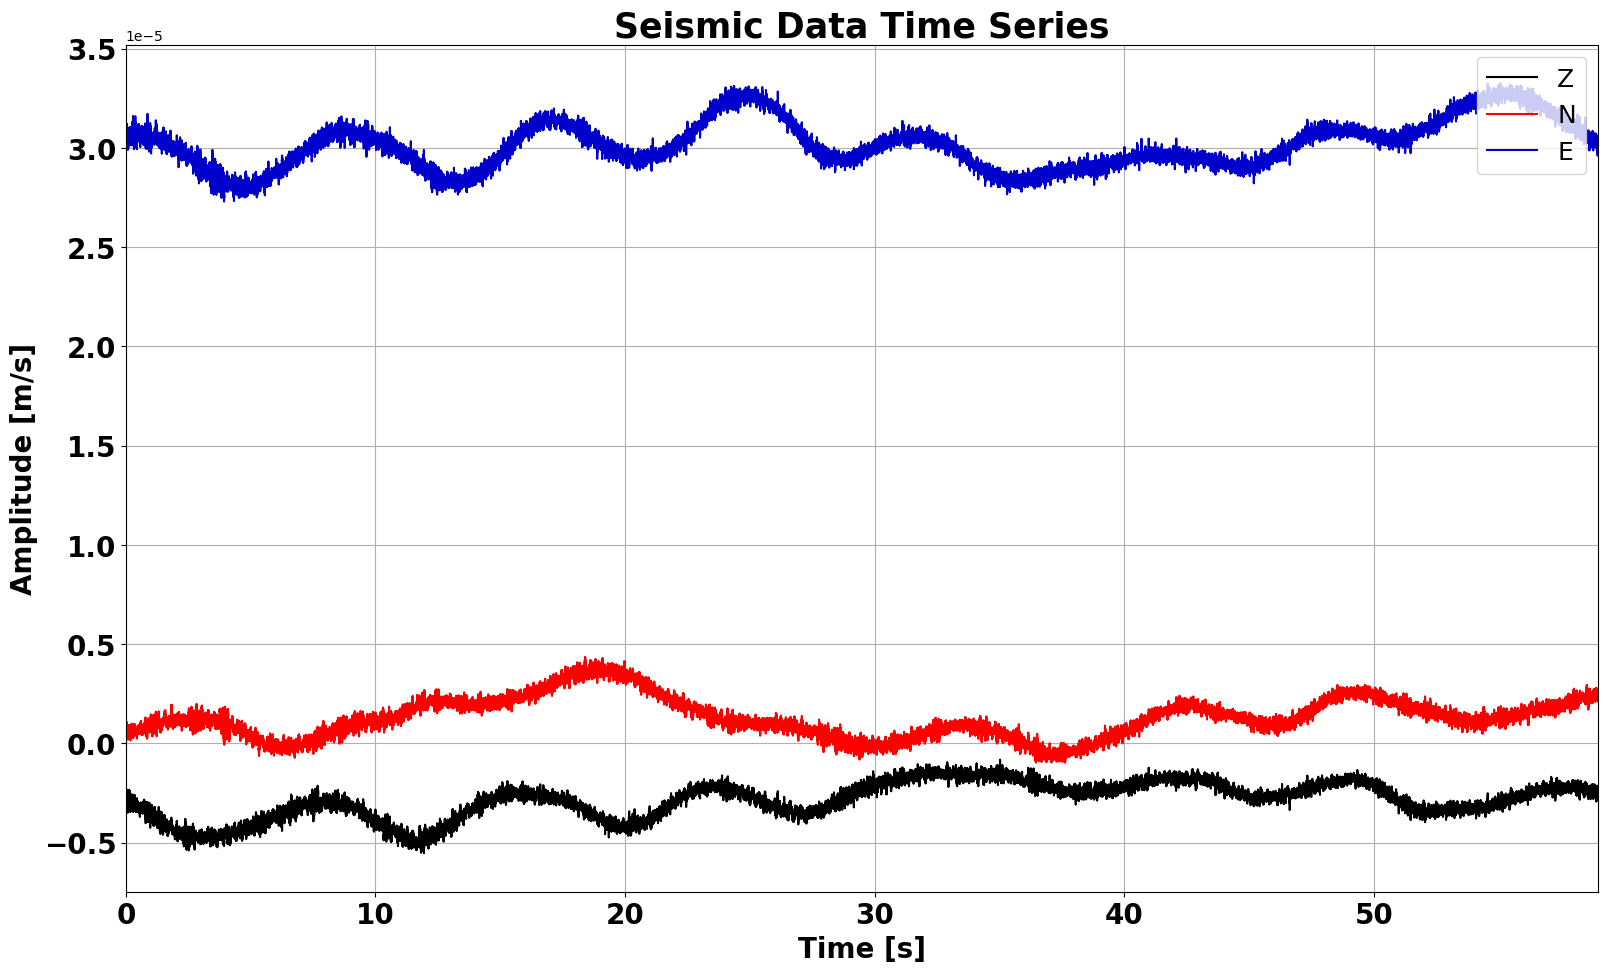

In [12]:
plt.figure(figsize = (19, 11))

####################### You can change the linestyle/order in which they are ploted for ease of viewing ########################

plt.plot(tim,z, linewidth = 1.5, color = 'black', label = 'Z') 
plt.plot(tim,n, linewidth = 1.5, color = 'red', label = 'N')
plt.plot(tim,e, linewidth = 1.5, color = 'mediumblue', label = 'E')
#plt.plot(tim,noi, linewidth = 1.5, color = 'yellow', label = 'Noise')

plt.legend(loc = "upper right", fontsize = 18)
plt.title("Seismic Data Time Series", fontweight = 'bold', fontsize = 25)
plt.xlabel("Time [s]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/s]", fontweight = "bold", fontsize = 20)
plt.xlim(0, tim[len(tim)-1])
#plt.ylim()
plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")
plt.grid(True)

#.savefig('**place_img_name_here.format**', bbox_inches='tight')

## If you want to look at a specific time along the time series, you can use the slider plot below. 

### These variables are used to adjust the how many seconds are displayed and the step length

In [4]:
win = 15  ## sec displayed
stepy = 4  ## sec moved

## Beware, there may be a slight time delay when slidering

## If the slider is not workering move to the next cell

In [5]:
Min = min(z.min(), n.min(), e.min())  ########################## This is to find the window height #############################
Max = max(z.max(), n.max(), e.max())

##################################### This function is what makes the slider run ###############################################
######################################### Parameters can be changed as needed ##################################################

def plot_with_slider(xlim):
    
    plt.figure(figsize=(19, 8))   ## dpi breaks slider
    
    plt.plot(tim, z, linewidth = 1.5, label = 'Z', color = 'black')
    plt.plot(tim, n, linewidth = 1.5, label = 'N', color = 'red')
    plt.plot(tim, e, linewidth = 1.5, label = 'E', color = 'blue')
    
    plt.xlim(xlim, xlim + win) ####################### This is how long the window is (CAN be changed) #########################
    plt.ylim(Min - 1, Max + 1) ################## This adds a buffer to the window height (CAN be changed) #####################
    
    plt.legend(loc = 'upper right', fontsize = 15)
    plt.title("Slider Time Series", fontweight = 'bold', fontsize = 25)
    plt.xlabel("Time [s]", fontweight = "bold", fontsize = 20)
    plt.ylabel("Amplitude [m/s]", fontweight = "bold", fontsize = 20)
    plt.yticks(fontsize = 20, fontweight = "bold")
    plt.xticks(fontsize = 20, fontweight = "bold")
    plt.grid(True)
    plt.show()

######################################## This is where the slider plot gets plotted ############################################
#### min,max = start,end ; step is the increment it slides on ; value is where it starts ; layout is how long the slider is ####
############################################### step and layout CAN be changed #################################################

interact(plot_with_slider, xlim = FloatSlider(min = 0, max = (tim[len(tim)-1]), step = stepy, value = 0, 
                                              layout=Layout(width='980px')))


interactive(children=(FloatSlider(value=0.0, description='xlim', layout=Layout(width='980px'), max=312.440645,…

<function __main__.plot_with_slider(xlim)>

## If you want to look at spectra of specific parts of the time series, you can set the time limits here

## If not, skip this cell

In [77]:
################################### Enter how long of a time segment you'd like to look at #####################################

start = 0  ## In terms of seconds
end = 11

############################################### This indexes the data frames ###################################################

gamma = int(start * sr)
delta = int(end * sr)

z1 = z[gamma:delta]
n1 = n[gamma:delta]
e1 = e[gamma:delta]

# These are variables to calculate the ASD and plot limits

In [3]:
#------------------------------------------------------ Plot limits -----------------------------------------------------------#
x_max = 100 ## in terms of frequency
x_min = 0.1

#--------------------------------------------------- Velocity Y limits --------------------------------------------------------#
y_max = 10e-6 ## in terms of m/s/Hz^0.5
y_min = 50e-12  

#------------------------------------------------- Displacement Y Limits ------------------------------------------------------#
my_max = 10e-7 ## in terms of m/Hz^0.5
my_min = 10e-12

#------------------------------------------------------ fft length ------------------------------------------------------------#
fft_length = 128 ## in terms of seconds

#-------------------------------------------------- Precent FFT Overlap -------------------------------------------------------#
overlap = 50 ## 50% fft overlap

# This cell is where the ASD is calculated and plotted

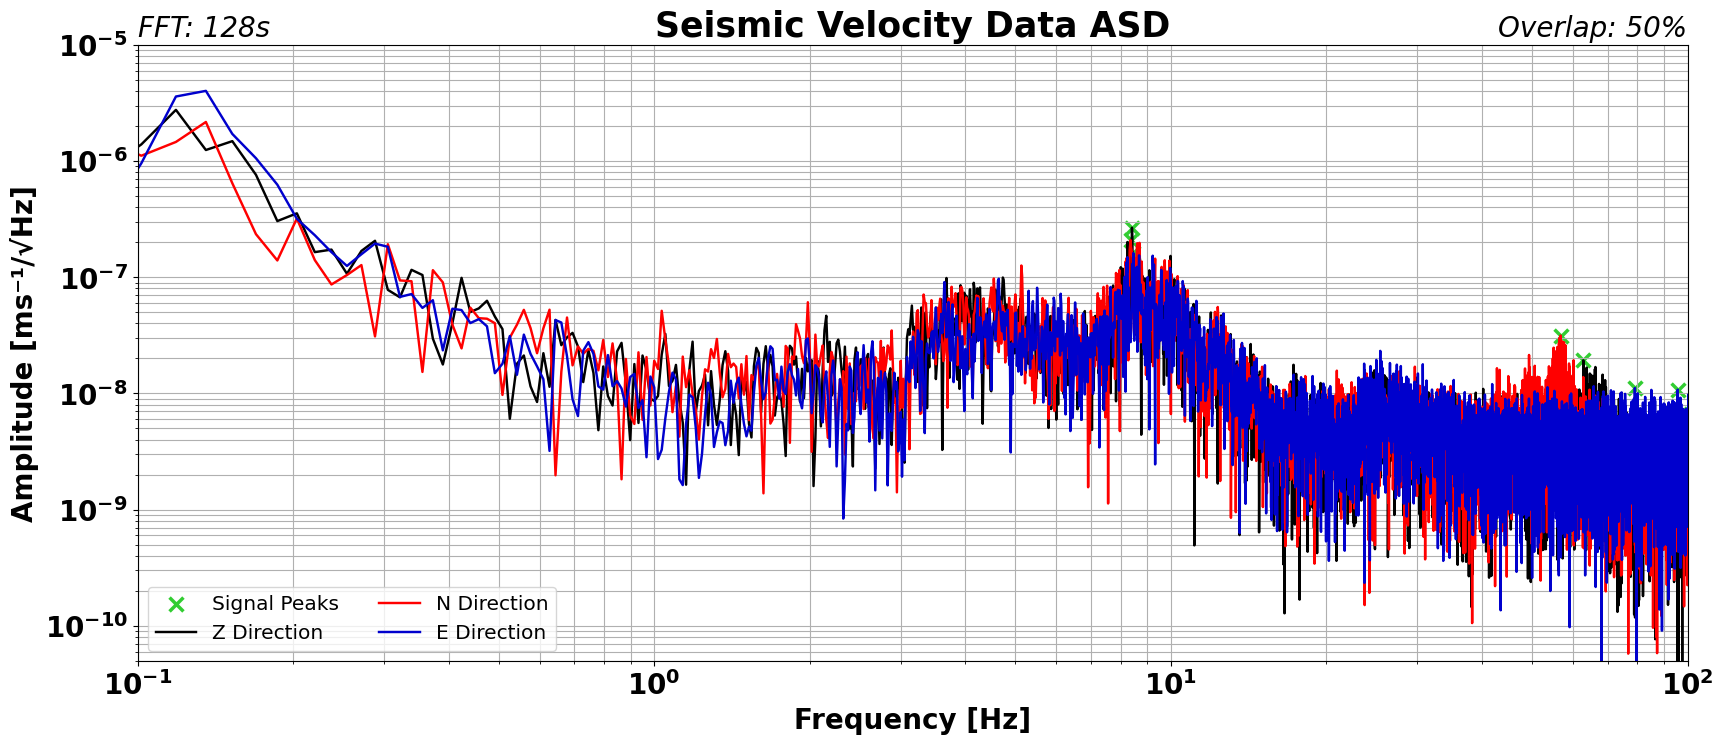

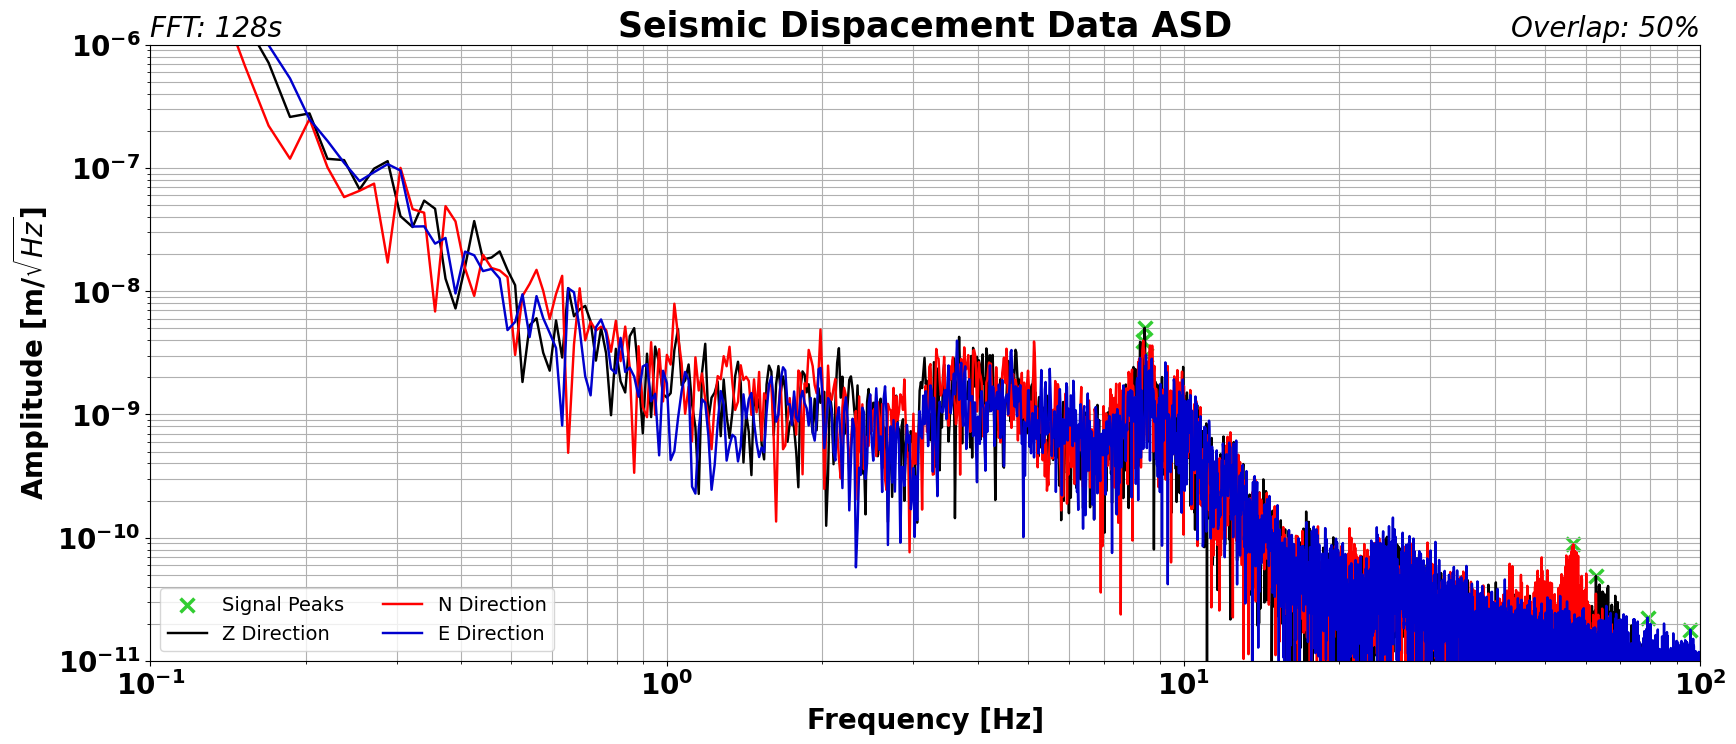

In [7]:
################################################################################################################################
######################################## The PSD is calculated via welch from scipy ############################################
################################################################################################################################
warnings.simplefilter('ignore')

############ If you don't want to look at the whole time series, you can add '1' to the variables, i.e k1, j1, i1 ##############
                           #  z1
f_z, Pxx_den_z = signal.welch(z, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_n, Pxx_den_n = signal.welch(n, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )
f_e, Pxx_den_e = signal.welch(e, sr, window= 'hamming', nperseg= (sr *fft_length), noverlap= round(sr *(overlap *0.01)) )

################### nfft is how long the fft bin lengths, noverlap is bin overlap, window is the window used ###################
####################### We used 100 sec bins, 0.5 sec overlap, and hamming window, these can be changed ########################
################################################ # DO NOT CHANGE/REMOVE 'fs' # #################################################


az = np.sqrt(Pxx_den_z)
an = np.sqrt(Pxx_den_n) ################################ This turns the PSD into an ASD ########################################
ae = np.sqrt(Pxx_den_e)

mz = az/ (2*np.pi *f_z)
mn = an/ (2*np.pi *f_n) ###################################### Converts m/s to m ###############################################
me = ae/ (2*np.pi *f_e)


log_z = np.log(az)
log_n = np.log(an) ############### The log of each ASD must be found in order to find the peaks/frequences #####################
log_e = np.log(ae)


peak_z, _ = signal.find_peaks(log_z, prominence = 5) ############## This is where the frequencies are found ###################
peak_n, _ = signal.find_peaks(log_n, prominence = 5) ############### If some are missed or there are extra ####################
peak_e, _ = signal.find_peaks(log_e, prominence = 5) ########## you will need to change the prominence variable ###############



###################################################### PLots data ##############################################################


################################################################################################################################
################################################### Plots Velocity #############################################################
################################################################################################################################

plt.figure(1, figsize = (20, 8))#, dpi = 2500)

plt.yscale('log')
plt.xscale('log')

##################################################### Plots Peaks ##############################################################

plt.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#################################################### PLots Spectra #############################################################

plt.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14.5, ncol = 2)

plt.title('FFT: ' + str(fft_length) + "s", fontsize = 20, loc = "left",style ='italic')
plt.title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

plt.title("Seismic Velocity Data ASD", fontweight = 'bold', fontsize = 25)

plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(y_min,y_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

################################################################################################################################
################################################## Plots Displacement ##########################################################
################################################################################################################################

plt.figure(2, figsize = (20, 8))#, dpi = 2500)
plt.yscale('log')
plt.xscale('log')

##################################################### Plots peaks ##############################################################

plt.scatter(f_z[peak_z], mz[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')
plt.scatter(f_n[peak_n], mn[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)
plt.scatter(f_e[peak_e], me[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5)

#################################################### PLots Spectra #############################################################

plt.plot(f_z, mz, color = 'black', linewidth = 1.75, label = 'Z Direction')
plt.plot(f_n, mn, color = 'red', linewidth = 1.75, label = 'N Direction')
plt.plot(f_e, me, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

plt.legend(loc = "lower left", fontsize = 14, ncol = 2)

plt.title('FFT: ' + str(fft_length) + "s", fontsize = 20, loc = "left",style ='italic')
plt.title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

plt.title("Seismic Dispacement Data ASD", fontweight = 'bold', fontsize = 25)
plt.xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 20)
plt.ylabel("Amplitude [m/√Hz]", fontweight = "bold", fontsize = 20)

plt.yticks(fontsize = 20, fontweight = "bold")
plt.xticks(fontsize = 20, fontweight = "bold")

plt.ylim(my_min,my_max)
plt.xlim(x_min,x_max)

plt.grid(True, which="both", ls="-")


#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cell will plot each of direction signal in their own respective plots
## It will also plot data from LIGO Hanford so that you can compare your data to what is generally found at LIGO

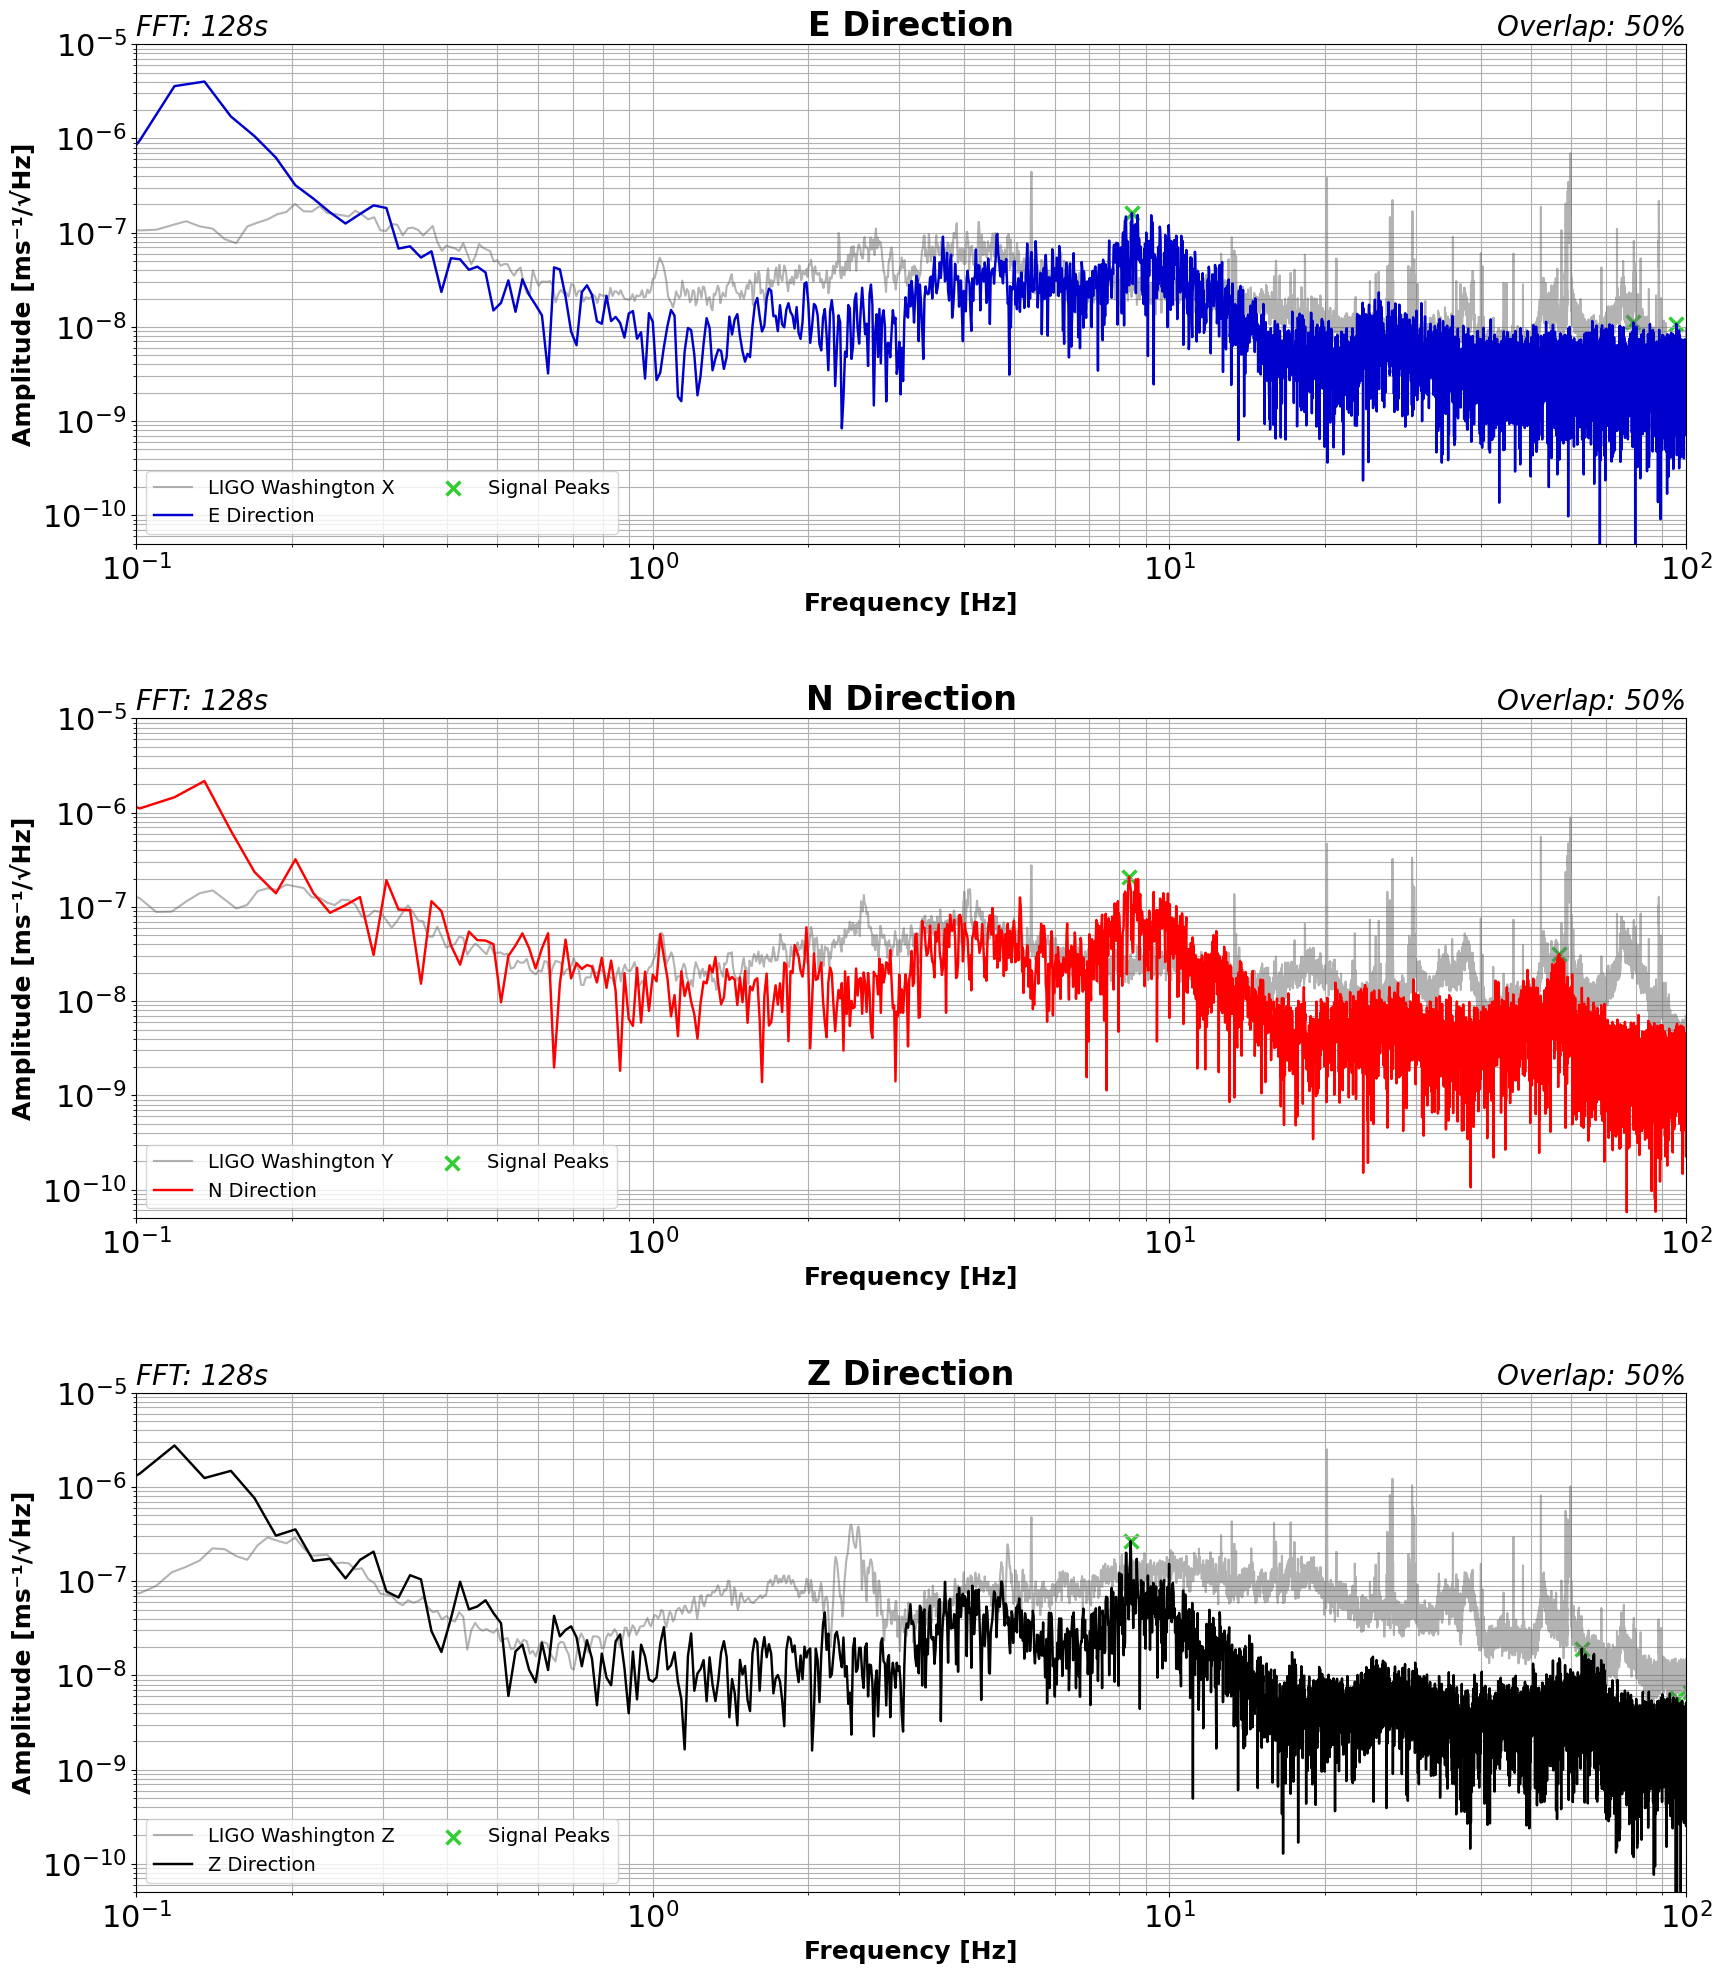

In [8]:
################################################################################################################################
############################# This gets plotted as a multipanel plot via gridspec and subplot ##################################
################################################################################################################################

fig = plt.figure(figsize = (20,24))
gs = gridspec.GridSpec(3,1, height_ratios = [1,1,1], hspace = 0.35)


####################################################### Channel E ##############################################################


axis1 = fig.add_subplot(gs[0,0])
axis1.set_yscale('log')
axis1.set_xscale('log')
axis1.tick_params(labelsize=22)

################################################### PLots LIGO Data ############################################################

axis1.plot(hf,hx, color = "dimgrey", label = "LIGO Washington X", alpha = 0.5)

################################################################################################################################

axis1.plot(f_e, ae, color = 'mediumblue', linewidth = 1.75, label = 'E Direction')

axis1.scatter(f_e[peak_e], ae[peak_e], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis1.set_title('FFT: ' + str(fft_length) + "s", fontsize = 20, loc = "left",style ='italic')
axis1.set_title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

axis1.set_title("E Direction", fontweight = "bold", fontsize = 24)

axis1.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis1.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis1.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis1.set_ylim(y_min,y_max)
axis1.set_xlim(x_min,x_max)
axis1.grid(True, which="both", ls="-")


####################################################### Channel N ##############################################################


axis2 = fig.add_subplot(gs[1,0])
axis2.set_yscale('log')
axis2.set_xscale('log')
axis2.tick_params(labelsize=22)

################################################### PLots LIGO Data ############################################################

plt.plot(hf,hy, color = "dimgrey", label = "LIGO Washington Y", alpha = 0.5)

################################################################################################################################

axis2.plot(f_n, an, color = 'red', linewidth = 1.75, label = 'N Direction')

axis2.scatter(f_n[peak_n], an[peak_n], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis2.set_title('FFT: ' + str(fft_length) + "s", fontsize = 20, loc = "left",style ='italic')
axis2.set_title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

axis2.set_title("N Direction", fontweight = "bold", fontsize = 24)

axis2.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis2.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis2.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis2.set_ylim(y_min,y_max)
axis2.set_xlim(x_min,x_max)
axis2.grid(True, which="both", ls="-")


####################################################### Channel Z ##############################################################


axis3 = fig.add_subplot(gs[2,0])
axis3.set_yscale('log')
axis3.set_xscale('log')
axis3.tick_params(labelsize=22)

################################################### PLots LIGO Data ############################################################

axis3.plot(hf,hz, color = "dimgrey", label = "LIGO Washington Z", alpha = 0.5)

################################################################################################################################

axis3.plot(f_z, az, color = 'black', linewidth = 1.75, label = 'Z Direction')

axis3.scatter(f_z[peak_z], az[peak_z], s = 100, color = 'limegreen', marker = 'x', 
            linewidths = 2.5, label = 'Signal Peaks')

axis3.set_title('FFT: ' + str(fft_length) + "s", fontsize = 20, loc = "left",style ='italic')
axis3.set_title("Overlap: " + str(overlap) + "%", fontsize = 20, loc = "right",style ='italic')

axis3.set_title("Z Direction", fontweight = 'bold' , fontsize = 24)

axis3.set_xlabel("Frequency [Hz]", fontweight = "bold", fontsize = 18)
axis3.set_ylabel("Amplitude [ms⁻¹/√Hz]", fontweight = "bold", fontsize = 18)
axis3.legend(loc = "lower left", fontsize = 14, ncol = 2)

axis3.set_ylim(y_min,y_max)
axis3.set_xlim(x_min,x_max)
axis3.grid(True, which="both", ls="-")



#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')

## The following cells are used to plot spectrograms for each direction

### These variables are to set limits for the plot and to compute the spectrogram

In [6]:
#-------------------------------------------------- Colorbar Limits -----------------------------------------------------------#
cmin = 10e-10
cmax = 10e-8

#---------------------------------------------------- Plot limits -------------------------------------------------------------#
ymax = 20 ## In terms of frequency
ymin = 0

#---------------------------------------------------- fft length --------------------------------------------------------------#
fft_len = 10 ## in terms of seconds

#------------------------------------------------ Precent FFT Overlap ---------------------------------------------------------#
olap = 50 ## 50% fft overlap

# This is where the spectrograms are plotted

'\naxis4 = fig.add_subplot(gs[3,0])\n\naxis4.set_title("Noise Direction", fontweight = \'bold\' , fontsize = 20)\n\nm3 = axis1.pcolormesh(t, f, np.sqrt(Sxx), shading=\'gouraud\') ############### This will autoscale the plot ###################\n                                                                \nm3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading=\'gouraud\', vmin = cmin, vmax = cmax)\n\naxis3.set_title("Electronic Noise", fontweight = \'bold\' , fontsize = 20)\naxis3.set_xlabel(\'Time [s]\', fontweight = \'bold\' , fontsize = 18)\naxis3.set_ylabel(\'Frequency [Hz]\', fontweight = \'bold\' , fontsize = 18)\naxis3.tick_params(labelsize=16)\n\ncbar3 = fig.colorbar(m3, pad = 0.02)\ncbar3.ax.tick_params(labelsize=14)\ncbar3.set_label(label=\'Intensity [m/s/Hz^0.5]\' ,weight=\'bold\', fontsize = 14)\n\n\naxis4.set_ylim(ymin, ymax) ## Uncomment to set limits\n\n#plt.savefig(\'**place_img_name_here.format**\', bbox_inches=\'tight\')\n'

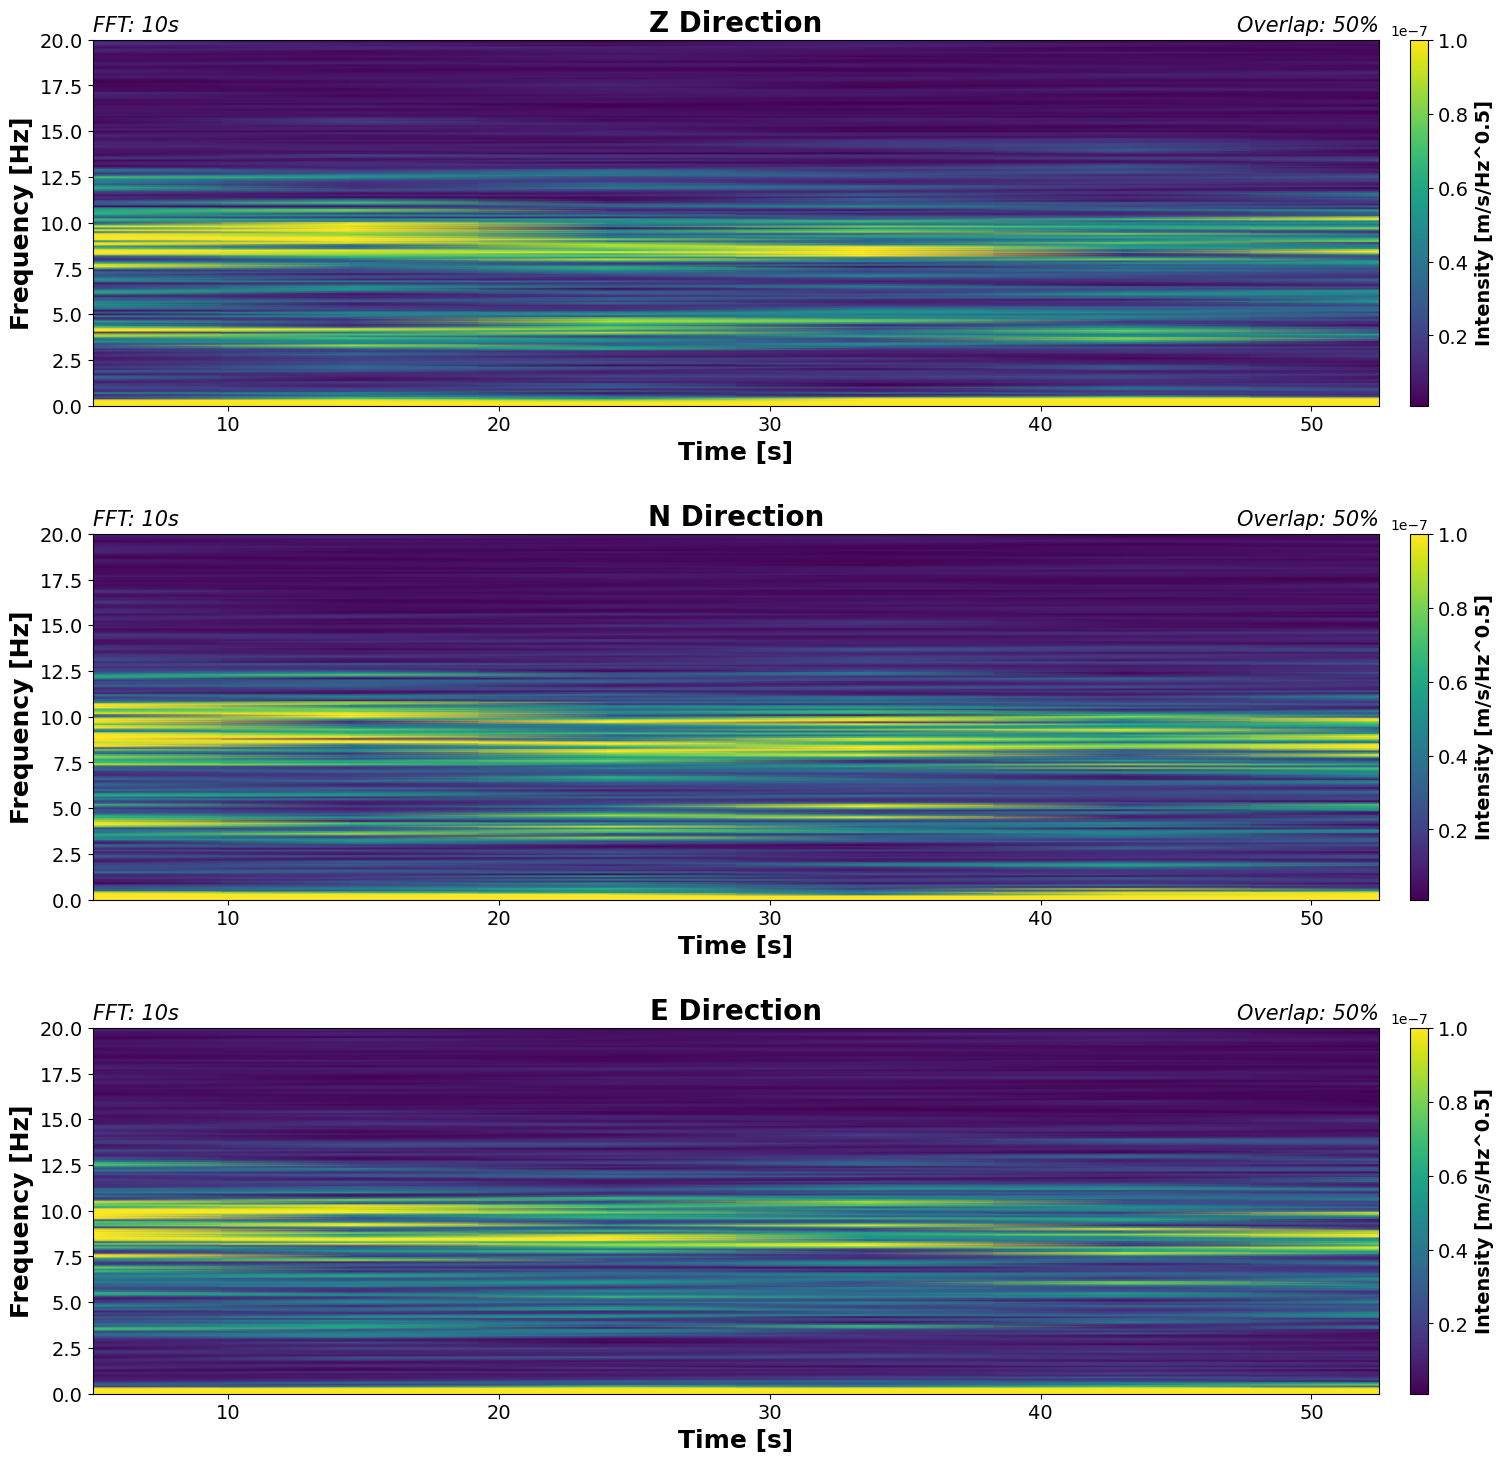

In [11]:
################################################################################################################################
###################### The spectrograms are calculated with signal.spectrogram from SciPy ######################################
################################################################################################################################
warnings.simplefilter('ignore')

fz, tz, Sxxz = signal.spectrogram(z, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fn, tn, Sxxn = signal.spectrogram(n, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
fe, te, Sxxe = signal.spectrogram(e, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )
#f, t, Sxx = signal.spectrogram(noi, sr, window= 'hamming', nperseg=round(sr *fft_len), noverlap= round(sr *(olap *0.01)) )


fig = plt.figure(figsize = (20,24))

gs = gridspec.GridSpec(4,1, height_ratios = [1,1,1,1], hspace = 0.35)

####################################################### Channel Z ##############################################################

axis1 = fig.add_subplot(gs[0,0])

#m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud')############### This will autoscale the plot ###################
                                                                ## If you want to change the limits, uncomment the line below ##
                                                                ########### Be sure to comment out the line above ##############

m0 = axis1.pcolormesh(tz, fz, np.sqrt(Sxxz), shading='gouraud', vmin = cmin, vmax = cmax)

axis1.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis1.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis1.set_title("Z Direction", fontweight = 'bold' , fontsize = 20)
axis1.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis1.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis1.tick_params(labelsize=14)

cbar0 = fig.colorbar(m0, label='Intensity [ms⁻¹/√Hz]', pad =0.02)
cbar0.ax.tick_params(labelsize=14)
cbar0.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)

axis1.set_ylim(ymin,ymax) ## Uncomment to set limits


####################################################### Channel N ##############################################################

axis2 = fig.add_subplot(gs[1,0])

#m1 = axis1.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud')############### This will autoscale the plot ###################
                                                                
m1 = axis2.pcolormesh(tn, fn, np.sqrt(Sxxn), shading='gouraud', vmin = cmin, vmax = cmax)

axis2.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis2.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis2.set_title("N Direction", fontweight = 'bold' , fontsize = 20)
axis2.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis2.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis2.tick_params(labelsize=14)

cbar1 = fig.colorbar(m1, pad =0.02)
cbar1.ax.tick_params(labelsize=14)
cbar1.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)

axis2.set_ylim(ymin, ymax)  ## Uncomment to set limits

####################################################### Channel E ##############################################################

axis3 = fig.add_subplot(gs[2,0])

#m2 = axis1.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud')############### This will autoscale the plot ###################
                                                                
m2 = axis3.pcolormesh(te, fe, np.sqrt(Sxxe), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title('FFT: ' + str(fft_len) + "s", fontsize = 15, loc = "left",style ='italic')
axis3.set_title("Overlap: " + str(olap) + "%", fontsize = 15, loc = "right",style ='italic')

axis3.set_title("E Direction", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=14)

cbar2 = fig.colorbar(m2, pad =0.02)
cbar2.ax.tick_params(labelsize=14)
cbar2.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)

axis3.set_ylim(ymin, ymax) ## Uncomment to set limits


###################################################### Noise Channel ###########################################################
'''
axis4 = fig.add_subplot(gs[3,0])

axis4.set_title("Noise Direction", fontweight = 'bold' , fontsize = 20)

m3 = axis1.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud') ############### This will autoscale the plot ###################
                                                                
m3 = axis4.pcolormesh(t, f, np.sqrt(Sxx), shading='gouraud', vmin = cmin, vmax = cmax)

axis3.set_title("Electronic Noise", fontweight = 'bold' , fontsize = 20)
axis3.set_xlabel('Time [s]', fontweight = 'bold' , fontsize = 18)
axis3.set_ylabel('Frequency [Hz]', fontweight = 'bold' , fontsize = 18)
axis3.tick_params(labelsize=16)

cbar3 = fig.colorbar(m3, pad = 0.02)
cbar3.ax.tick_params(labelsize=14)
cbar3.set_label(label='Intensity [ms⁻¹/√Hz]' ,weight='bold', fontsize = 14)


axis4.set_ylim(ymin, ymax) ## Uncomment to set limits

#plt.savefig('**place_img_name_here.format**', bbox_inches='tight')
'''
################################################################################################################################
################################## These will take a while to plot, since they are so dense ####################################

## This cell will output all the frequencies found and their respective amplitudes into a csv file

In [68]:
####################################################### # # # # # # ############################################################
################################################### # SPAGHETTI CODE # #########################################################
###################################################### # # # # # # # ###########################################################
################################################################################################################################
###################################### Since each direction has a different number of peaks ####################################
############################################### They cannot be printed out right ###############################################
########################################### So they have to be made the same length ############################################
################################################################################################################################

l = 0 ################################################## Variables for loops ###################################################
m = 0
o = 0
q = 0

index = [] ############################################ Empty sets to be appended to ###########################################
roll = []
inventory = []

tsukishima = max(len(f_e[peak_e]), len(f_n[peak_n]), len(f_z[peak_z])) # Finds the directions with the most peaks, i.e longest #

for q in range(0, tsukishima - len(f_e[peak_e])): ############# The shorter data sets will be made equal with 'Nan' ############
    inventory.append(np.nan)                      ################## Nothing will happen to the longest set ####################
for m in range(0, tsukishima - len(f_n[peak_n])): ################ If they are the same length nothing happens #################
    index.append(np.nan)
for o in range(0, tsukishima - len(f_z[peak_z])):
    roll.append(np.nan)

################################################################################################################################
######################################### This path is where the file gets outputted ###########################################
####################################################### Change as need #########################################################

with open (r"outfile.csv",'w') as f: 
        f.write('Frequency_E (HZ), Amplitude_E (m/s/HZ^0.5), Frequency_N (Hz), Amplitude_N (m/s/HZ^0.5), Frequency_Z (Hz), Amplitude_Z (m/s/HZ^0.5)\n')
        
        for l in range(0, tsukishima):
            if (len(f_e[peak_e]) != len(f_n[peak_n]) or len(f_e[peak_e]) != len(f_z[peak_z]) or len(f_n[peak_n]) != len(f_z[peak_z])):                
                if len(f_e[peak_e]) == tsukishima:      
                    
############################################# The files are made the same length ###############################################

                    dir3 = np.append(f_n[peak_n], index)
                    dir_3 = np.append(an[peak_n], index)
                    dir4 = np.append(f_z[peak_z], roll)
                    dir_4 = np.append(az[peak_z], roll)

##################################### This where the dat points get printed in the file ########################################

                    f.write(str(f_e[peak_e][l]) + ',' + str(ae[peak_e][l]) + ',' +    
                            str(dir3[l]) + ',' + str(dir_3[l]) + ',' +
                            str(dir4[l]) + ',' + str(dir_4[l]) + '\n')
                    
###################### The elif's are for if a different direction has more peaks, longest data set ############################

                elif len(f_n[peak_n]) == tsukishima:
                    
                    dir3 = np.append(f_e[peak_e], inventory)
                    dir_3 = np.append(ae[peak_e], inventory)
                    dir4 = np.append(f_z[peak_z], roll)
                    dir_4 = np.append(az[peak_z], roll)
                    
                    f.write(str(dir3[l]) + ',' + str(dir_3[l]) + ',' +    
                            str(f_n[peak_n][l]) + ',' + str(an[peak_n][l]) + ',' +
                            str(dir4[l]) + ',' + str(dir_4[l]) + '\n')

                    
                elif len(f_z[peak_z]) == tsukishima:
                    
                    dir3 = np.append(f_e[peak_e], inventory)
                    dir_3 = np.append(ae[peak_e], inventory)
                    dir4 = np.append(f_n[peak_n], index)
                    dir_4 = np.append(an[peak_n], index)
                    
                    f.write(str(dir3[l]) + ',' + str(dir_3[l]) + ',' +    
                            str(dir4[l]) + ',' + str(dir_4[l]) + ',' +
                            str(f_z[peak_z][l]) + ',' + str(az[peak_z][l]) + '\n')

############################### If the data sets are the same length the data will be printed here #############################

            else:
                f.write(str(f_e[peak_e][l]) + ',' + str(ae[peak_e][l]) + ',' +    
                        str(f_n[peak_n][l]) + ',' + str(an[peak_n][l]) + ',' +
                        str(f_z[peak_z][l]) + ',' + str(az[peak_z][l]) + '\n')
print('It ran (づ｡◕‿‿◕｡)づ')

It ran
